# Go to [Empirical null hypothesis](#Empirical_null_hypothesis)

In [1]:
import os, sys
path_libraries = os.path.abspath('../libraries/')
sys.path.append(path_libraries)

from predictions_Logo_library import *
# import libraries
data = initialize_notebook_and_load_datasets()
# generate indices to split data
_train, _test, _valid = generate_split_index(data)

In [3]:
import itertools

# list all "k"-mers that exist in the sequence "seq"
def kmerize(seq, k):
    return ' '.join(seq[i:i+k] for i in range(len(seq) -k +1))

# generate all possible k-mers from "aa" list 
def kmers(k):
    return [''.join(kmers) for kmers in itertools.product(aa, repeat=k)]

# generate one column for each of all possible kmers in data (k=2 here)
for kmer in kmers(2):
    data[kmer] = [kmerize(seq, 2).count(kmer) / 29. for seq  in data.index] 

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, auc, roc_curve, make_scorer

# generate combination of 2mers
_2mers = [''.join(i) for i in itertools.product(aa,aa)]

# define train,test,valid data
Xtrain, ytrain = data.loc[_train, _2mers].values, data.loc[_train, 'TAD'].values
Xtest, ytest = data.loc[_test, _2mers].values, data.loc[_test, 'TAD'].values
Xvalid, yvalid = data.loc[_valid, _2mers].values, data.loc[_valid, 'TAD'].values

# compute the model (default "l2")
model = LogisticRegressionCV(Cs = np.linspace(1e-4, 1e4, 60), scoring = make_scorer(roc_auc_score)).fit(Xtrain, ytrain)

In [4]:
# initialize the 2D weights matrix
weights = np.zeros(shape=(len(aa), len(aa)))

# get coefficients of model
coefs = model.coef_[0]
coefs = (coefs - np.min(coefs)) / (np.max(coefs) - np.min(coefs))

# 
for position, value in zip([i for i in itertools.product(aa,repeat=2)], coefs):
    x,y = aa.index(position[0]), aa.index(position[1])
    weights[x][y] = value


roc_auc_score(yvalid, model.predict_proba(Xvalid)[:,1])

0.9731101848347468

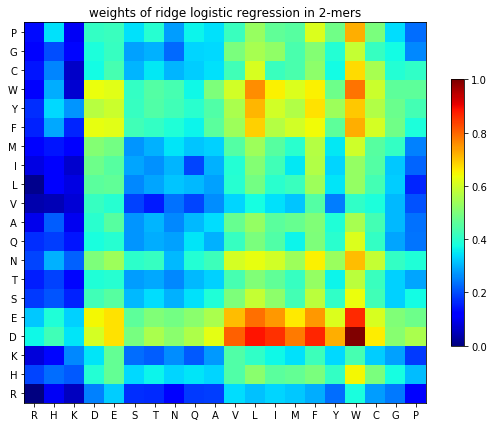

In [5]:
f, ax = plt.subplots(1, figsize=(9,7))
im = ax.pcolor(weights, cmap='jet')
ax.set_xticks(np.arange(20)+0.5)
ax.set_yticks(np.arange(20)+0.5)
ax.set_xticklabels(aa)
ax.set_yticklabels(aa);
plt.colorbar(im, shrink=0.7)
plt.title('weights of ridge logistic regression in 2-mers');
#plt.savefig('weights_of_ridge_logistic_regression_in_2_mers.jpg', dpi=1200)

In [17]:
# try using 10 to 100% of the data and see if performance and weigths change much

# In weights all sub-weights will be stored, in rocs, roc_auc values will be stored 
weights = []
rocs = []

for fraction in np.linspace(0.1,1,10):
    
    # get subsample
    subsamples = int(fraction * Xtrain.shape[0])
    Xsubtrain, ysubtrain = Xtrain[:subsamples], ytrain[:subsamples]
    
    #train the model
    model = LogisticRegressionCV(Cs=np.linspace(1e-4, 1e4, 60), scoring = make_scorer(roc_auc_score)).fit(Xsubtrain, ysubtrain)
    
    # compute a weights matrix
    sub_weights = np.zeros(shape=(len(aa), len(aa)))

    # get coefficients of model
    coefs = model.coef_[0]
    coefs = (coefs - np.min(coefs)) / (np.max(coefs) - np.min(coefs))

    # fill the sub_weights matirs and append to weights
    for position, value in zip([i for i in itertools.product(aa,repeat=2)], coefs):
        x,y = aa.index(position[0]), aa.index(position[1])
        sub_weights[x][y] = value
    weights.append(sub_weights)

    rocs.append(roc_auc_score(yvalid, model.predict_proba(Xvalid)[:,1]))

Text(0,0.5,'performance')

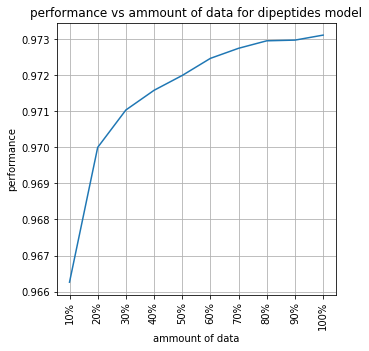

In [21]:
f,ax = plt.subplots(figsize=(5,5))
plt.title("performance vs ammount of data for dipeptides model")
ax.plot(rocs)
ax.grid()
ax.set_xticks(np.arange(10))
ax.set_xticklabels([str(i)+'%' for i in np.arange(10,101,10)], rotation=90)
ax.set_xlabel('ammount of data')
ax.set_ylabel('performance')

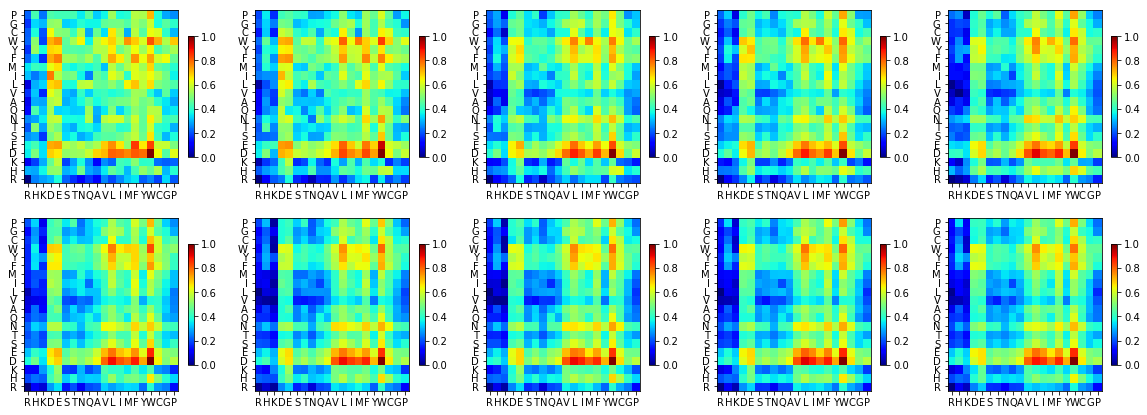

In [22]:
plt.figure(figsize=(20,7))
for n,i in enumerate(weights):
    ax = plt.subplot(2,5,n+1)
    im = ax.pcolor(i, cmap='jet')
    ax.set_xticks(np.arange(20)+0.5)
    ax.set_yticks(np.arange(20)+0.5)
    ax.set_xticklabels(aa)
    ax.set_yticklabels(aa);
    plt.colorbar(im, shrink=0.7)
    #plt.title('weights of ridge logistic regression in 2-mers');

In [29]:
# Make frames for a short gif showing performance of 2mer model and heatmap.
from matplotlib import gridspec

for n,w in enumerate(weights):
    
    # create figure
    plt.figure(figsize=(5,6))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 6]) 
        
    # plot y_axis=score and x_axis=subsmple% 
    ax0 = plt.subplot(gs[0])
    ax0.plot(np.arange(1,n+1), np.array(rocs)[:n])
    ax0.set_xlim(0,10)
    ax0.set_ylim(0.966, 0.975)
    ax0.grid()
    ax0.set_title('performance of ridge logistic regression vs 2mers distance')
    
    # plot the heatmap of 2mers combined
    ax1 = plt.subplot(gs[1])
    im = ax1.pcolor(w, cmap='jet')
    ax1.set_xticks(np.arange(20)+0.5)
    ax1.set_yticks(np.arange(20)+0.5)
    ax1.set_xticklabels(aa)
    ax1.set_yticklabels(aa)
    ax1.set_title('heatmap 2mers coefficients in the logistic model')
    
    #plt.tight_layout()
    
    plt.savefig('heatmap_'+str(n+1)+'.jpg', dpi=300)
    plt.close()

# Predictions on yeast activators

In [2]:
from predictions_library import *

In [3]:
# prepare dfs. IMPORTANT: these "properties.fasta" contain MUCH more sequences than positive+negative. 
# Reduce it to the index that will be used and discard ALL sequences that are not going to be used.
reduced_index, labels = data.index, data.TAD

# load and get ohe matrices of all secondary structures and disorder
ss_psipred = load_predicted_properties(myHOME+ '/data/30mers_ALL.PSIPRED_ss.fasta')
ss_psipred_set = list(set(np.concatenate([i for i in ss_psipred.values])))
# One hot encode all categorical variables
def ohe_wrap(data, categories): return np.array([ohe(data.loc[i], categories) for i in reduced_index])
ss_psipred = ohe_wrap(ss_psipred, ss_psipred_set)

# combine all variables together, categorical and numerical
sequences = np.array([ohe(seq, aa) for seq in reduced_index])
ohe_data = np.vstack([sequences.T, ss_psipred.T]).T

/home/ariel/Desktop/TAD_analysis/data/30mers_ALL.PSIPRED_ss.fasta loaded succesfully!


In [4]:
import keras.backend as K
from keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.activations import softplus, softsign


# Split data 8:1:1 
idx = np.arange(ohe_data.shape[0])
np.random.seed=0
np.random.shuffle(idx)
_8, _9 = int(ohe_data.shape[0]*0.8), int(ohe_data.shape[0]*0.9)
train, test, valid = idx[:_8], idx[_8:_9], idx[_9:]

shape = ohe_data.shape
ohe_data = ohe_data.reshape(tuple(list(shape)+[1]))

# define the sets with ALWAYS same split 
Xtrain, Xtest, Xvalid = [ohe_data[i] for i in [train, test, valid]]
ytrain, ytest, yvalid = [labels[i] for i in [train, test, valid]]



# Due to technical reasons, optimization of the model was done with a sbatch command.
from keras.models import model_from_json

K.clear_session()
inputs = Input(shape=(30,Xtrain.shape[2],1))
x = Conv2D(29, (4,Xtrain.shape[2]), activation=softplus)(inputs)
x = Flatten()(x)
x = Dense(300, activation=softplus)(x)
x = Dropout(0.3)(x)
x = Dense(30, activation=softplus)(x)
output = Dense(1, activation='sigmoid')(x)
deep_model = Model(inputs=inputs, outputs=output)

# before compiling the model, load the winner weights 
deep_model.load_weights(myHOME + '/models/winner_weights.h5')

# compile with winner weights
deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

roc_auc_score(yvalid, deep_model.predict(Xvalid))

Using TensorFlow backend.


0.9793631429416936

# Look for extreme samples in charges vs predictions

In [30]:
# reduced_index
# ohe_data
# labels
# predictions
#charges
predictions = [deep_model.predict(i.reshape(np.append(1,i.shape)))[0][0] for i in ohe_data]
charges = [calculate_charge(i) for i in reduced_index]

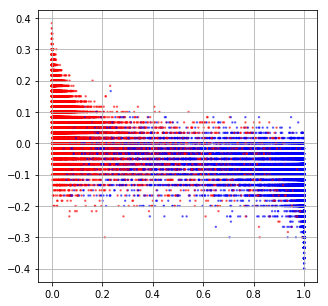

In [75]:
plt.figure(figsize=(5,5))
cols = ['r' if i==0 else 'b' for i in labels ]
plt.scatter(predictions, charges, s=2, alpha=0.5, c=cols)
plt.grid()

In [66]:
df_weirds = np.vstack([charges, predictions, list(labels)])
df_weirds = pd.DataFrame(df_weirds.T, index=list(reduced_index), columns = ['charges','predictions','labels'])

In [76]:
#df_weirds[(df_weirds.charges<-0.25) & (df_weirds.labels==0) & (df_weirds.predictions>0.6)]
# Apply MEME motif discovery to find any significant motif in these sequences.
import uuid
for i in df_weirds[(df_weirds.charges<-0.25) & (df_weirds.labels==0) & (df_weirds.predictions>0.6)].index:
    print('>' + str(uuid.uuid4()) + '\n' + i)

>89dc2b73-f7b0-4e67-9278-1a69101365c4
EEDALVGIVDYEMKLKFGEERNEEEVLEAE
>5dabec47-f5ca-429c-bc07-8822d0def21f
ETTDDECVEEVIVCDVYLDENCDTQTGLGK
>adc9964f-84d3-4b3e-a49b-1261db59e106
VVVTEDIAGEEEDFMGSDEYGEKEYDCVGL
>1baffee7-96c0-4a76-a70a-a450f5dd19ee
YDVGDFDYTCVHDEQAVIEEVDKPDEGVVN
>85fcf2d6-2dc0-4172-85a9-2fbf0f215f3c
CEDDDSNEEEITTELLIAYAVGKAWFEVCL
>0e35b26c-32e5-4f6d-9cef-a27b7e1a923e
KLTEEDVGGEDEVVEQIDWAFCIESKDIDG
>784678d5-d7a1-43de-b60c-2326619fb2ed
SVVCDVDISDEHECCDGGIDDFVQMYASEY
>bd079893-6a8c-41e5-9601-177152ce9525
FAESIDVGDFGMERIVENEESVMGVDVEDG
>16650303-c839-4a5a-b481-9897bf2a2cdd
SIQTASTEVDSDEENDLVGAECTTVDCSCF
>6b3e55ee-2d97-47b6-abfc-233700b0bea1
MDSNETIMDFQSGLDTESLEQTSWDGPDGQ
>c62a8324-13ef-4834-a51f-8638cf458b7f
FTEGVCCQLLRVADYDGENDNVDIVVDDFD
>00a5daa1-07c7-4ae9-87a0-5464c7a78ce5
NDEDPVVYLVESDEWNIVLDGSDSVNDDEI
>8f2f68eb-341a-4f4c-85a3-c4ea141f5949
VEFNVYVTIDVDEETSVEEEFFMNLCAATW
>c7b36f3e-1635-4800-aad6-3dc43f7681c8
LINGDVVVVVGVEDEGVEAEDFDEVATLYA


In [77]:
for i in df_weirds[(df_weirds.charges>0.15) & (df_weirds.labels==1) & (df_weirds.predictions<0.2)].index:
    print('>' + str(uuid.uuid4()) + '\n' + i)

>ac9c5817-b052-40a2-ab43-9d0dbcc1ce5e
IIKTGVFTGLRQNSRGSRVGRVPRGFGPGG
>46557579-0e14-4a8e-b8ec-6a6143261478
IVIVIASAAVCGNVVKYSKGKKWDYKKMIA
>a02e1ce8-8b71-4b57-aa0d-2f8162b0a5dc
FGTVAPMNVFLWHRRCLHGGRHNRGLYSLI
>5a3e73de-85e5-4a3e-b264-9dba6435e1cf
RGLCLRGRPYAVWPRHIGKVFWSSSSTVSP
>a76ed06d-b78c-45f9-b606-308b43cc8054
SYSFGTLGCTGVKKHASSGMVKRIHRGTAM
>5483b686-0c3c-438f-bea3-bde04a311e7a
ACLNLWCQKVGNRLTRVCPYIAQINVRKSS
>43c29841-06f6-40fc-8603-ab427ff7e5f3
FWDEPRHQCGSRMILRRKSTTGFGLRPGLR
>e4da4542-c6fe-4614-b611-9802f0571e2f
YTIFRYSRHCGRPHGQALAPGPSTHVTFRK
>b3dc5650-c133-49f8-b222-b4edb8c46dda
GGMFWLGRSSRQVIPTKVRRRHNLDVGSAM
>62051d35-0cfa-4df6-bff4-a890bfe0a3ac
NTYGFCIIMRRVKCAKYIVYTNINKVRDIY
>b84117d0-32aa-4c40-9ce2-9db844770277
CLRRASWSLCTRSFTNSRWSVGKYTSGPVS
>6ccf490d-60eb-458a-84b8-60bf5794f097
SRVETCHCYPRLHNNRCVSRFLQWHRPRGS
>534d3894-2b06-48a4-aeed-942fd706da17
RGMSNCVSPRRSAKACKYTSRVWLYMDYFG
>95661cb2-9ec4-4821-b49a-17a5b26b6626
MVAHGRIGFPNHRLRGARPFLVTTRKAATW
>4da31728-4d18-4096-9808-3b09b4032

### couldn't find any significant motif or patter on neither these sets of sequences

# Predicting values of natural activators and saturated mutagenesis

In [5]:
# gcn4
gcn4_sequence = myHOME + '/data/gcn4.fasta'
gcn4_ss = myHOME + '/data/gcn4.horiz'

# met4
met4_sequence = myHOME + '/data/met4.fasta'
met4_ss = myHOME + '/data/met4.horiz'

# ino2
ino2_sequence = myHOME + '/data/ino2.fasta'
ino2_ss = myHOME + 'data/ino2.horiz'

# gal4
gal4_sequence = myHOME + '/data/gal4.fasta'
gal4_ss = myHOME + '/data/gal4.horiz'

# mtf1
mtf1_sequence = myHOME + '/data/mtf1_fly.fasta'
mtf1_ss = myHOME + '/data/mtf1_fly.horiz'

In [36]:
seq = open_fasta(gcn4_sequence)
ss = open_ss(gcn4_ss)
ohe_gcn4 = ohe_single(seq,ss, aa_list=aa, ss_list=ss_psipred_set)

predictions = []
for i in range(0, len(ss)-30):
    region = deep_model.predict(ohe_gcn4[0, i:i+30, :, 0].reshape(1,30,23,1))[0][0]
    predictions.append(region)

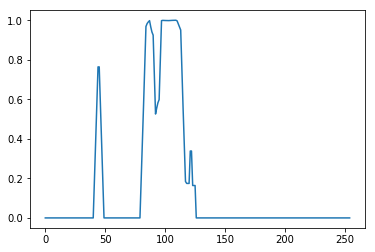

In [37]:
plt.plot(np.convolve([i if i>=0.8 else 0 for i in predictions], np.ones(5)/5))

### LEFT FOR LATER: 
INVESTIGATE: When sliding the prediction window, a region that appears to be part of the tAD when this region i...

# Print sequencing profiles of Stark sequences. 

In [533]:
Stark_data_genome = open_fasta(myHOME + '/data/Stark_tADs/GSE114387_TFbb_list180_linear.fa')
Stark_data_annot = pd.read_csv('../data/Stark_tADs/TFtracks.bed', delimiter='\t', header=None, names=['_','start','end']+['_']*6, index_col=3).iloc[:,1:3]

# convert bigWig into wig to access GFP files
BP_STEP = 1 #read data from bw every x bases 
from subprocess import run
run(['/home/ariel/Documents/tools/bwtool/bwtool/bwtool', 'chromgraph','-every='+str(BP_STEP), 
     myHOME + '/data/Stark_tADs/short-library_GFP-_1+.bw', myHOME + '/data/Stark_tADs/short-library_GFP-_1+.wig'])
run(['/home/ariel/Documents/tools/bwtool/bwtool/bwtool', 'chromgraph','-every='+str(BP_STEP), 
     myHOME + '/data/Stark_tADs/short-library_GFP+_1+.bw', myHOME + '/data/Stark_tADs/short-library_GFP+_1+.wig'])

# load them into dictionaries
gfp_p = read_wig(myHOME + '/data/Stark_tADs/short-library_GFP+_1+.wig')
gfp_m = read_wig(myHOME + '/data/Stark_tADs/short-library_GFP-_1+.wig')

# remove wig files from memory
run(['rm', myHOME + '/data/Stark_tADs/short-library_GFP+_1+.wig']) 
run(['rm', myHOME + '/data/Stark_tADs/short-library_GFP-_1+.wig'])

# prepare all fasta files to use in psipred predictions
''' for i in Stark_data_annot.index:
    filename = i + '.fasta'
    start, end = Stark_data_annot.loc[i, ['start', 'end']]
    dna_sequence = Stark_data_genome[start:end]
    protein_seq = translate_dna2aa(dna_sequence)
    f = open(filename, 'w')
    f.write('>'+i+'\n'+protein_seq)
    f.close()''';

done! /home/ariel/Desktop/TAD_analysis/data/Stark_tADs/short-library_GFP+_1+.wig file loaded
done! /home/ariel/Desktop/TAD_analysis/data/Stark_tADs/short-library_GFP-_1+.wig file loaded


In [270]:
for sample in np.arange(0,181,30):
    plt.figure(figsize=(20,24))
    for n, TF_name in enumerate(Stark_data_annot.index[sample:sample+30]):
        
        # if ss file is not here yet, skip
        if not os.path.exists('../data/Stark_tADs/horiz/'+ TF_name + '.horiz'): continue

        # open fasta and horiz files and generate ohe
        seq = open_fasta('../data/Stark_tADs/fastas/'+ TF_name + '.fasta')
        ss = open_ss('../data/Stark_tADs/horiz/'+ TF_name + '.horiz')
        single = ohe_single(seq,ss, aa_list=aa, ss_list=ss_psipred_set)

        # predict using deep_model
        predictions = []
        for i in range(0, len(ss)-30):
            region = deep_model.predict(single[0, i:i+30, :, 0].reshape(1,30,23,1))[0][0]
            predictions.append(region)

        #plot predictions
        plt.subplot(6,5,n+1)
        plt.fill_between(range(len(predictions)), predictions, alpha=0.3)
        plt.plot(np.convolve([i if i>=0.8 else 0 for i in predictions], np.ones(10)/10, "same"), lw=3)
        plt.xlabel('protein position')
        plt.ylabel('NN score');
        
        
        # plot gfp+ and gfp-
        start, end = Stark_data_annot.loc[TF_name, ['start','end']]
        plus = gfp_p.iloc[start:end].counts.values
        minus = gfp_m.iloc[start:end].counts.values
        # make plus and minus averaged every 3 nt to plot together with protein 
        plus = np.array([np.mean(plus[i:i+3]) for i in np.arange(0, len(plus), 3)])
        minus = np.array([np.mean(minus[i:i+3]) for i in np.arange(0, len(minus), 3)])

        # take values of tADs whose plus/minus >2 and plus >100 counts
        tAD = plus/minus
        tAD = np.array([k if k>2 and i>100 else 0 for i,k in zip(plus, tAD)])
        tAD = (tAD - np.min(tAD)) / (np.max(tAD) - np.min(tAD))

        plt.plot(tAD)
        #plt.plot(plus)
        #plt.plot(minus)
        plt.legend(['GFP+', 'GFP-'])
        plt.title(TF_name)
        plt.tight_layout()
    #plt.savefig('predictions_Stark_' + str(sample) + '-' + str(sample+30) + '.jpg')

# Empirical permutation null hypothesis <a class="anchor" id="Empirical_null_hypothesis"></a>
$i$: position index  
$f$: factor index  
  
$\vec{prediction}: p{\lbrack}f{\rbrack\lbrack}i{\rbrack}$  
$\vec{measurement}: m{\lbrack}f{\rbrack\lbrack}i{\rbrack}$  

Algorithm:  
* Draw permutation of $\{1..f\}p_{i}{\lbrack}f{\rbrack}$
* Concatenate (unroll) all $p{\lbrack} p_{i}{\lbrack}f{\rbrack} {\rbrack}{\lbrack}i{\rbrack}$
* Concatenate (unroll) all $m{\lbrack}f{\rbrack}{\lbrack}i{\rbrack}$
* Compute correlation between unrolled $m{\lbrack}f{\rbrack}{\lbrack}i{\rbrack}$ and $pi{\lbrack}f{\rbrack} {\rbrack}{\lbrack}i{\rbrack}$  
pearson -->  $corr(m,p)=(1/N)\sum_{j} \frac{(m_{j} - \bar{m}) * (p_{j} - \bar{p})} {(\sigma_{p}*\sigma_{m})}$   
  
  
Then either measure the proportion of the area under the curve from that point (correlation of the original p vector, without permutation) to its right or left (for positive or negative value)

In [534]:
Stark_data_annot = Stark_data_annot.drop('Su(var)2-10_FBtr0088576', axis=0)

# original factor and position indexes
f = list(Stark_data_annot.index)  ####################################################################--> I should ONLY use genes that show enrichment over the background

# generate tables of measurements and predictions for genes in Stark data
m_dict = make_m_dict(Stark_data_annot, gfp_p, gfp_m)
p_dict = make_p_dict(Stark_data_annot, deep_model)

# join values into vectors for measurements and predictions.
m = np.concatenate([m_dict[i][:-30] for i in f]) # [:-30] because I didn't predict score for these residues 
p = np.concatenate([p_dict[i] for i in f])


# compute original correlation 
corr = np.corrcoef(m,p)[0][1]

### Assuming that p value is the probability of type-I error, this area should be the equivalent
corr_distrib = build_distribution(f,p_dict)

p_value = calc_typeI_error(corr_distrib, corr, plot=True, bins=100)
plt.title("p_value with cut_off=2 and reads=100: {} ".format(p_value));

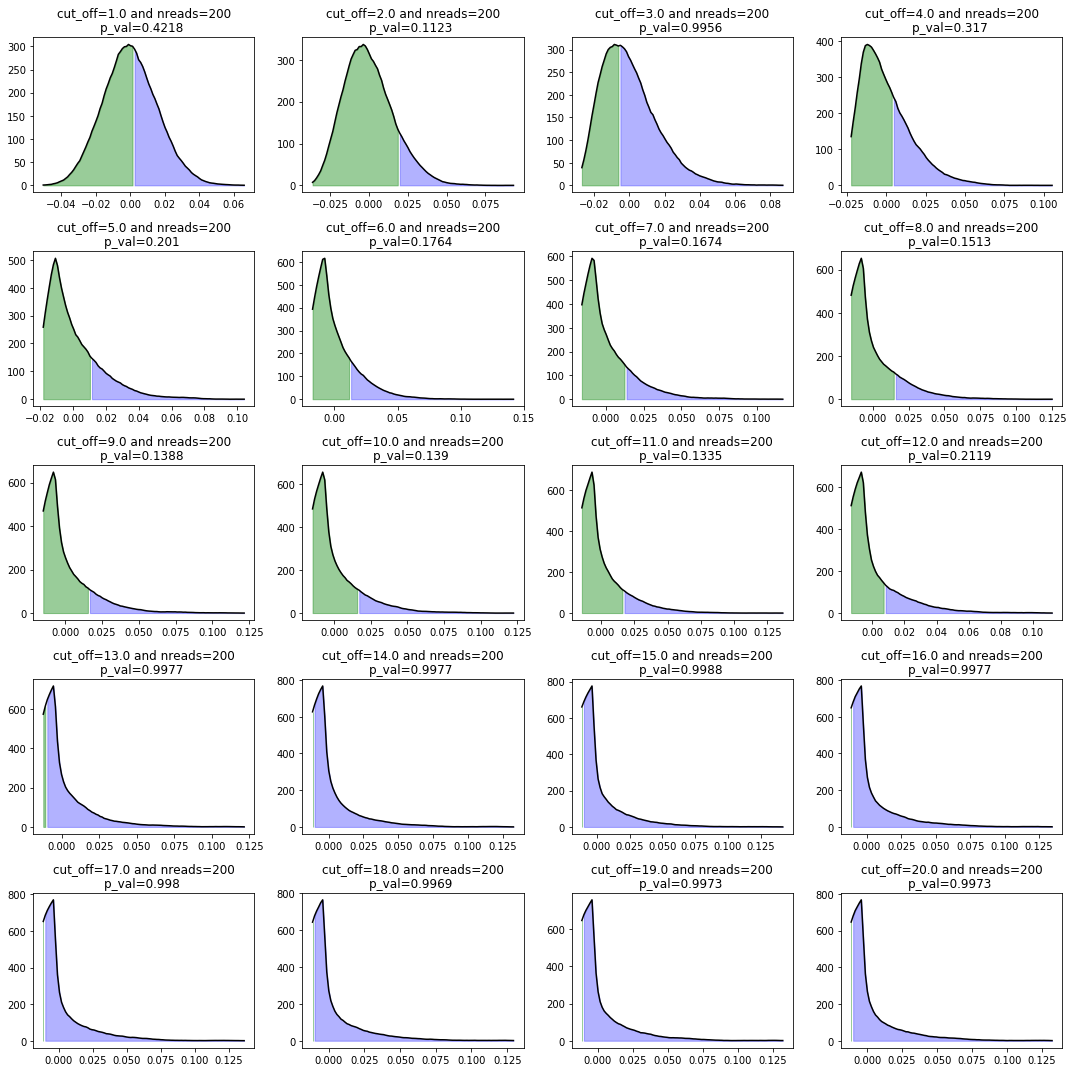

In [631]:
plt.figure(figsize=(15,15))

MINIMUM_READS = 200
cutoffs = np.linspace(1,20,20)
for n,FOLD_CHANGE_THRESHOLD in enumerate(cutoffs):
    
    # generate tables of measurements and predictions for genes in Stark data
    m_dict = make_m_dict(Stark_data_annot, gfp_p, gfp_m, MINIMUM_READS=MINIMUM_READS, FOLD_CHANGE_THRESHOLD=FOLD_CHANGE_THRESHOLD)
    p_dict = make_p_dict(Stark_data_annot, deep_model)

    # join values into vectors for measurements and predictions.
    m = np.concatenate([m_dict[i][:-30] for i in f]) # [:-30] because I didn't predict score for these residues 
    p = np.concatenate([p_dict[i] for i in f])


    # compute original correlation 
    corr = np.corrcoef(m,p)[0][1]

    ### Assuming that p value is the probability of type-I error, this area should be the equivalent
    corr_distrib = build_distribution(f,p_dict, n_iter=10000)
    
    # make it as subplots
    plt.subplot(5,4,n+1)
    
    p_value = calc_typeI_error(corr_distrib, corr, plot=True, bins=100)
    plt.title("cut_off={} and nreads={}\np_val={} ".format(FOLD_CHANGE_THRESHOLD, MINIMUM_READS, p_value));
    
plt.tight_layout()
plt.savefig('empirical_nullH_p_values_completeSet_reads-{}-cutOffs-{}'.format(MINIMUM_READS, cutoffs)+'.jpg')

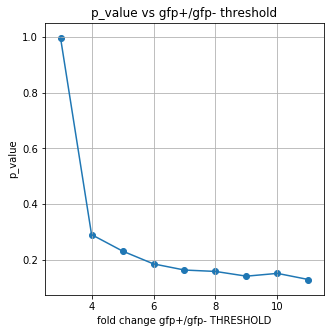

In [553]:
plt.figure(figsize=(5,5))
plt.grid()
plt.xlabel('fold change gfp+/gfp- THRESHOLD')
plt.ylabel('p_value')
plt.plot(range(3,12), [0.995, 0.291, 0.232, 0.186, 0.164, 0.159, 0.142, 0.152, 0.13])
plt.scatter(range(3,12), [0.995, 0.291, 0.232, 0.186, 0.164, 0.159, 0.142, 0.152, 0.13])
plt.title('p_value vs gfp+/gfp- threshold');
plt.savefig('p_value__VS__threshold_minReads-{}-cutOffs-{}'.format(MINIMUM_READS, cutoffs)+'.jpg')

### If we use the subset of Stark's TF with real peaks judging by eye the p_value should be smaller and the drop might be deeper.

In [619]:
# A: plot TFs with a region (longer than three amino-acids) with fold change=3 and reads>200. 
### That region should be detected as a peak, nevertheless, most of these peaks look like a 
### overamplified single sequence, since it starts and ens very sharply
# B = A, except that ther should be no peak on the gfp- where the enrichment peak is detected.

#########
### A ###
#########

# in lista I store tfs with requirements
lista = []

for tf in f:
    s,e = Stark_data_annot.loc[tf,['start','end']].values

    # signal is from gene NOT FROM PROTEIN => region should be at least 9 bp long.
    signal = np.nan_to_num([gfp_p.iloc[i].values[0] / gfp_m.iloc[i].values[0] 
                            if gfp_p.iloc[i].values[0]>200 else 0 for i in range(s,e)])

    # positions where requirements are valid
    signal = np.where(signal>2)[0]
    # return True if there is region FC>2 and reads>200 else False
    if len(signal)<9:
        continue

    for position in range(9, len(signal)-18):
        if signal[position] - signal[position-9] == 9:
            lista.append(tf)
            break

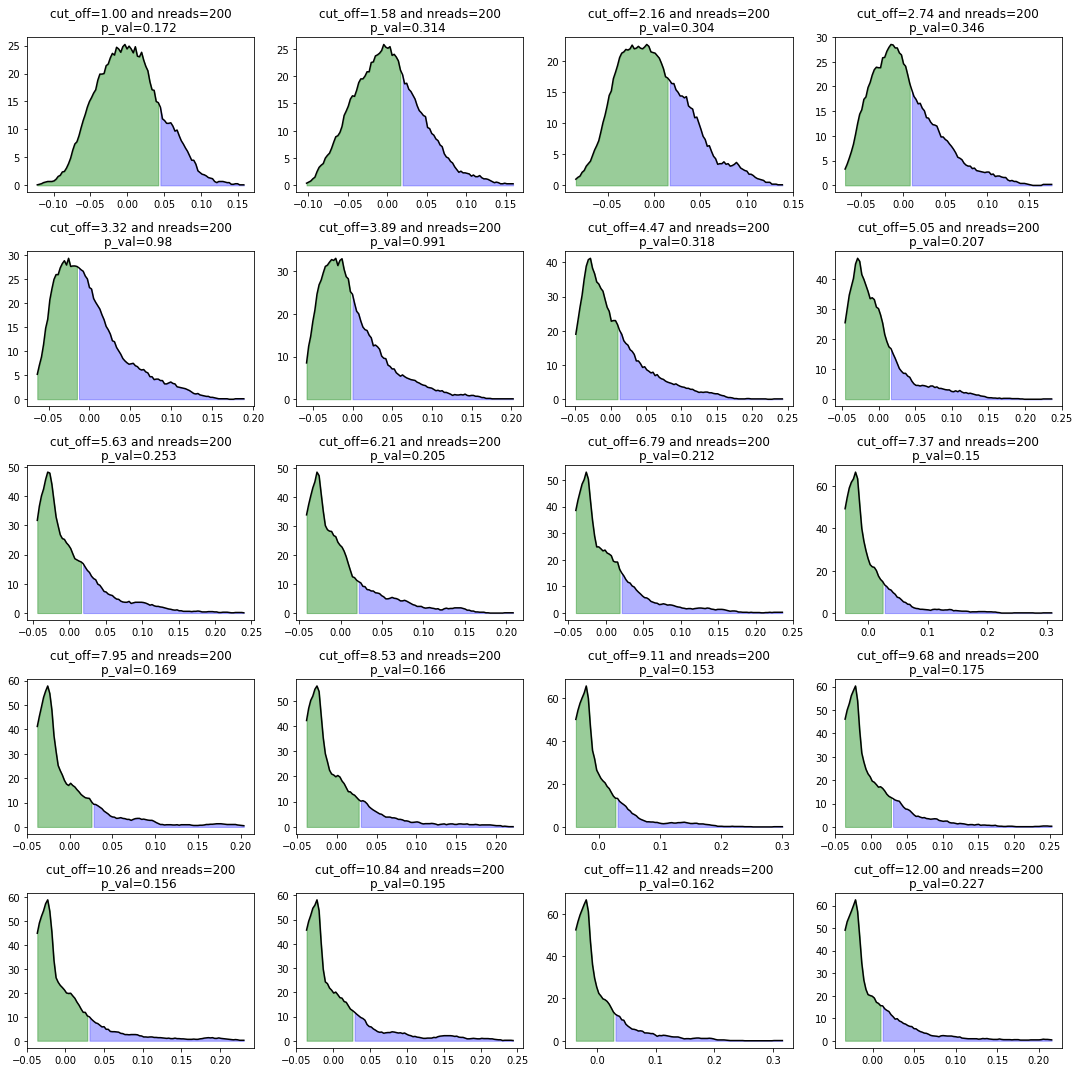

In [626]:
plt.figure(figsize=(15,15))

MINIMUM_READS = 200
cutoffs = np.linspace(1,12,20)
for n,FOLD_CHANGE_THRESHOLD in enumerate(cutoffs):
    
    # generate tables of measurements and predictions for genes in Stark data
    m_dict = make_m_dict(Stark_data_annot.loc[lista], gfp_p, gfp_m, MINIMUM_READS=MINIMUM_READS, FOLD_CHANGE_THRESHOLD=FOLD_CHANGE_THRESHOLD)
    p_dict = make_p_dict(Stark_data_annot.loc[lista], deep_model)

    # join values into vectors for measurements and predictions.
    m = np.concatenate([m_dict[i][:-30] for i in lista]) # [:-30] because I didn't predict score for these residues 
    p = np.concatenate([p_dict[i] for i in lista])


    # compute original correlation 
    corr = np.corrcoef(m,p)[0][1]

    ### Assuming that p value is the probability of type-I error, this area should be the equivalent
    corr_distrib = build_distribution(lista,p_dict, n_iter=1000)
    
    # make it as subplots
    plt.subplot(5,4,n+1)
    
    p_value = calc_typeI_error(corr_distrib, corr, plot=True, bins=100)
    plt.title("cut_off={:.2f} and nreads={}\np_val={} ".format(FOLD_CHANGE_THRESHOLD, MINIMUM_READS, p_value));
    
plt.tight_layout()
plt.savefig('empirical_nullH_p_values_completeSet_reads-{}'.format(MINIMUM_READS)+'__30_TFs.jpg')

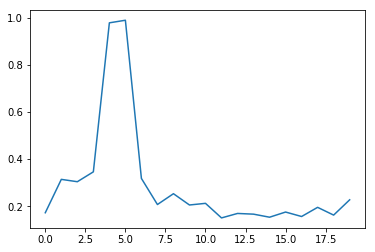

In [630]:
vals = ([0.172, 0.314, 0.304, 0.346, 0.98 , 0.991, 0.318, 0.207, 0.253,0.205, 0.212, 0.15 , 0.169, 0.166, 0.153, 0.175, 0.156, 0.195,0.162, 0.227])
plt.plot(vals)

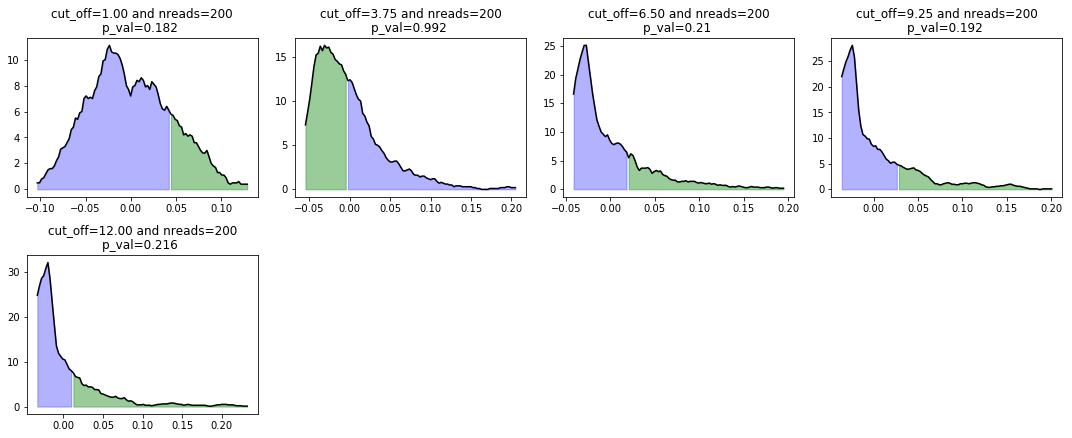

In [635]:
def calc_typeI_error(corr_values, point, **kwargs):
    '''
        function makes distribution out of correlation values (corr_values)
        and calculate the area under "normal" curve as extreme or more extreme than point,
        that is the probability that a number falls on the right of the point in that curve(
        if point is positive, else to the left of the point).
        INPUT = corr_values (list of values of correlation) and point (single sample to test)
        optional = bins (bins=100) and plot (plot=True)
        OUTPUT = type I error or area under the curve from point to the right or 
                 point to the left if point is negative value.
    '''
    # allow user to input bins number
    if 'bins' in kwargs.keys(): bins=kwargs['bins']
    else: bins=100
    
    # make histogram of corr_values
    y,x = np.histogram(corr_values, bins=bins)
    
    # have to make x.shape=y.shape
    x = x[:-1]
    
    # allow user to plot the distribution
    if 'plot' in kwargs.keys():
        if kwargs['plot']==True:
            yc = np.convolve(y, np.ones(10)/10, "same")
            if point>0:
                _right = np.where(x>=point)
                _left = np.where(x<point)
                plt.plot(x, yc, c="k")
                plt.fill_between(x[_right], yc[_right], color='g', alpha=0.4)
                plt.fill_between(x[_left], yc[_left], color='b', alpha=0.3)
            else:
                _left = np.where(x<=point)
                _right = np.where(x>point)                
                plt.plot(x, yc, c="k")
                plt.fill_between(x[_right], yc[_right], color='b', alpha=0.3)
                plt.fill_between(x[_left], yc[_left], color='g', alpha=0.4)
    
    # if point is negative, flip the curve and make point positive
    if point<0:
        point = point*-1.
        y = y[::-1]
    
    # measure total area and area from point to it's right
    total_area = np.sum(y)
    index_point2right = np.where(x>=point) 
    area_point_right = np.sum(y[index_point2right])
    
    # typeI error
    probaTypeI = area_point_right *1. / total_area            
            
    return probaTypeI




plt.figure(figsize=(15,15))

MINIMUM_READS = 200
cutoffs = np.linspace(1,12,5)
for n,FOLD_CHANGE_THRESHOLD in enumerate(cutoffs):
    
    # generate tables of measurements and predictions for genes in Stark data
    m_dict = make_m_dict(Stark_data_annot.loc[lista], gfp_p, gfp_m, MINIMUM_READS=MINIMUM_READS, FOLD_CHANGE_THRESHOLD=FOLD_CHANGE_THRESHOLD)
    p_dict = make_p_dict(Stark_data_annot.loc[lista], deep_model)

    # join values into vectors for measurements and predictions.
    m = np.concatenate([m_dict[i][:-30] for i in lista]) # [:-30] because I didn't predict score for these residues 
    p = np.concatenate([p_dict[i] for i in lista])


    # compute original correlation 
    corr = np.corrcoef(m,p)[0][1]

    ### Assuming that p value is the probability of type-I error, this area should be the equivalent
    corr_distrib = build_distribution(lista,p_dict, n_iter=500)
    
    # make it as subplots
    plt.subplot(5,4,n+1)
    
    p_value = calc_typeI_error(corr_distrib, corr, plot=True, bins=100)
    plt.title("cut_off={:.2f} and nreads={}\np_val={} ".format(FOLD_CHANGE_THRESHOLD, MINIMUM_READS, p_value));
    
plt.tight_layout()
plt.savefig('empirical_nullH_p_values_completeSet_reads-{}'.format(MINIMUM_READS)+'__30_TFs.jpg')